<a href="https://colab.research.google.com/github/rasan142857/arandomhuman/blob/master/thesis_trial_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import h5py
import os
import numpy as np
# from elephant.conversion import BinnedSpikeTrain
# from elephant.spike_train_correlation import corrcoef
# from elephant.statistics import isi, cv, mean_firing_rate
# import quantities as pq
# import elephant.statistics as es
from scipy.spatial.distance import euclidean
# import elephant.spike_train_generation as stg
import scipy.stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from scipy.optimize import curve_fit
import random
import ast

In [2]:
import pickle

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures


In [4]:
import matplotlib.pyplot as plt

In [5]:
from sklearn.metrics import mean_squared_error


In [6]:
from sklearn.impute import SimpleImputer

In [8]:
# Load all_normalized_summ_stats from a file using pickle
with open('all_normalized_summ_stats.pickle', 'rb') as f:
    all_normalized_summ_stats = pickle.load(f)

# Load netw_params from a file using pickle
with open('netw_params.pickle', 'rb') as f:
    netw_params = pickle.load(f)

In [9]:
netw_params[0]

{'C_YX': array([[0.05 , 0.135],
        [0.079, 0.16 ]]),
 'J': 87.81,
 'N_X': array([21915,  5479]),
 'd_E': 1.5,
 'd_I': 0.75,
 'g_YX': array([[ 0.92787187, -6.85599082],
        [ 0.58303918, -3.57576077]]),
 'k_ext_X': array([2100, 1900]),
 'population_names': array([b'L4E', b'L4I'], dtype='|S3')}

In [10]:
all_normalized_summ_stats[0]

({'mean_fire_rate': 0.0005658224960073009,
  'fanofactor': 0.130272952853598,
  'mean_interspike_interval': 1184.54,
  'mean_cv': nan},
 {'mean_fire_rate': 0.05577660156962949,
  'fanofactor': 0.8730890052356021,
  'mean_interspike_interval': 297.95090361445784,
  'mean_cv': nan})

In [63]:
def euclidean_distance(observed_stats_e, observed_stats_i, comparison_stats_e, comparison_stats_i, weights=None):
    if weights is None:
        keys = list(observed_stats_e.keys()) + list(observed_stats_i.keys())
        weights = {key: 1.0 for key in keys}
        print(observed_stats_e.keys())
    distance = 0
    for key in observed_stats_e.keys():
        if not (np.isnan(observed_stats_e[key]) or np.isnan(comparison_stats_e[key])):
            distance += weights[key] * (observed_stats_e[key] - comparison_stats_e[key]) ** 2
    for key in observed_stats_i.keys():
        if not (np.isnan(observed_stats_i[key]) or np.isnan(comparison_stats_i[key])):
            distance += weights[key] * (observed_stats_i[key] - comparison_stats_i[key]) ** 2
    distance = np.sqrt(distance)
    return distance

def rejection_abc(aggregated_stats_l4e, aggregated_stats_l4i, mod_params, threshold_distance):
    accepted_params = []
    accepted_distances = []
    accepted_stats_e = []
    accepted_stats_i = []
    np.random.seed(142857)
    # Randomly sample observed data
    idx = np.random.randint(len(mod_params))
    param, aggr_stats_e, aggr_stats_i = mod_params[idx], aggregated_stats_l4e[idx], aggregated_stats_l4i[idx]

    for idx_compare, (aggr_stats_e_compare, aggr_stats_i_compare) in enumerate(zip(aggregated_stats_l4e, aggregated_stats_l4i)):
        if idx_compare == idx:
            continue

        weights={'mean_fire_rate':0.4, 'fanofactor':0.2, 'mean_interspike_interval':0.2, 'mean_cv':0.2}
        distance = euclidean_distance(aggr_stats_e, aggr_stats_i, aggr_stats_e_compare, aggr_stats_i_compare, weights)
        # print(distance)
        if distance <= threshold_distance:
            accepted_params.append(mod_params[idx_compare])
            accepted_distances.append(distance)
            accepted_stats_e.append(aggregated_stats_l4e[idx_compare])
            accepted_stats_i.append(aggregated_stats_l4i[idx_compare])

    return accepted_params, accepted_distances, accepted_stats_e, accepted_stats_i, aggr_stats_e, aggr_stats_i


# Normalize all summary statistics
all_normalized_summ_stats_l4e, all_normalized_summ_stats_l4i = zip(*all_normalized_summ_stats)

# Run Rejection ABC with a definable threshold distance
threshold_distance = 1
accepted_params, accepted_distances, accepted_stats_e, accepted_stats_i, sampled_stats_e, sampled_stats_i = rejection_abc(all_normalized_summ_stats_l4e, all_normalized_summ_stats_l4i, netw_params, threshold_distance)

In [64]:
print(sampled_stats_e, sampled_stats_i)

{'mean_fire_rate': 0.00010951403148528405, 'fanofactor': 0.0, 'mean_interspike_interval': nan, 'mean_cv': nan} {'mean_fire_rate': 0.05154225223580945, 'fanofactor': 0.6680453257790369, 'mean_interspike_interval': 308.5724422442244, 'mean_cv': nan}


In [65]:
len(accepted_params)

127

In [46]:
def linear_adjustment(observed_stats_e, observed_stats_i, accepted_stats_e, accepted_stats_i, accepted_g_YX):
    observed_stats = np.concatenate((list(observed_stats_e.values()), list(observed_stats_i.values())))
    accepted_stats = [np.concatenate((list(s_e.values()), list(s_i.values()))) for s_e, s_i in zip(accepted_stats_e, accepted_stats_i)]

    # Replace NaN values with 0
    observed_stats = np.nan_to_num(observed_stats)
    accepted_stats = np.nan_to_num(accepted_stats)

    X = np.vstack(accepted_stats)
    y = np.array(accepted_g_YX).reshape(-1, np.array(accepted_g_YX).shape[-1] * np.array(accepted_g_YX).shape[-2])  # Flatten the last two dimensions

    # Create a linear regression model
    model = LinearRegression()

    # Fit the model with the data
    model.fit(X, y)

    # Predict the g_YX parameters for the observed_statistics
    predicted_observed_parameters = model.predict(observed_stats[None, :])

    # Calculate the difference (delta) between the original g_YX parameters and the
    # predicted g_YX parameters for each accepted sample
    deltas = y - model.predict(X)

    # Apply the delta to the predicted ground truth
    adjusted_parameters = predicted_observed_parameters + deltas

    # Reshape adjusted_parameters back to the original shape of accepted_g_YX
    adjusted_parameters = adjusted_parameters.reshape(np.array(accepted_g_YX).shape)

    return adjusted_parameters

In [47]:
# Extract accepted g_YX parameters
accepted_g_YX = [param['g_YX'] for param in accepted_params]
print(accepted_g_YX[0])
# Perform linear adjustment

[[ 1.30082626 -8.36654378]
 [ 0.76339231 -5.23484304]]


In [48]:
print(np.shape(accepted_g_YX))

(43, 2, 2)


In [49]:
adjusted_g_YX = linear_adjustment(sampled_stats_e, sampled_stats_i, accepted_stats_e, accepted_stats_i, accepted_g_YX)

In [50]:
print(adjusted_g_YX[0])

[[  1.53687028 -10.48068341]
 [  0.29788421  -3.10601198]]


In [51]:
print(accepted_g_YX[0])


[[ 1.30082626 -8.36654378]
 [ 0.76339231 -5.23484304]]


In [52]:
def nonlinear_adjustment(model_type, observed_stats_e, observed_stats_i, accepted_stats_e, accepted_stats_i, accepted_g_YX, poly_degree=None):
    assert model_type in ['linear', 'polynomial', 'decision_tree', 'random_forest'], "Invalid model_type. Choose from 'linear', 'polynomial', 'decision_tree', or 'random_forest'."
    if model_type == 'polynomial':
        assert poly_degree is not None, "For polynomial model, please provide a value for the 'poly_degree' argument."

    observed_stats = np.concatenate((list(observed_stats_e.values()), list(observed_stats_i.values())))
    accepted_stats = [np.concatenate((list(s_e.values()), list(s_i.values()))) for s_e, s_i in zip(accepted_stats_e, accepted_stats_i)]

    # Replace NaN values with 0
    observed_stats = np.nan_to_num(observed_stats)
    accepted_stats = np.nan_to_num(accepted_stats)

    X = np.vstack(accepted_stats)
    y = np.array(accepted_g_YX).reshape(-1, np.array(accepted_g_YX).shape[-1] * np.array(accepted_g_YX).shape[-2])  # Flatten the last two dimensions

    if model_type == 'polynomial':
        # Create a polynomial features transformer
        poly_features = PolynomialFeatures(degree=poly_degree)
        X_poly = poly_features.fit_transform(X)
        observed_stats_poly = poly_features.transform(observed_stats[None, :])

    # Create a regression model based on the chosen type
    if model_type == 'linear':
        model = LinearRegression()
    elif model_type == 'polynomial':
        model = LinearRegression()
    elif model_type == 'decision_tree':
        model = DecisionTreeRegressor()
    elif model_type == 'random_forest':
        model = RandomForestRegressor()

    # Fit the model with the data
    if model_type == 'polynomial':
        model.fit(X_poly, y)
    else:
        model.fit(X, y)

    # Predict the g_YX parameters for the observed_statistics
    if model_type == 'polynomial':
        predicted_observed_parameters = model.predict(observed_stats_poly)
    else:
        predicted_observed_parameters = model.predict(observed_stats[None, :])

    # Calculate the difference (delta) between the original g_YX parameters and the
    # predicted g_YX parameters for each accepted sample
    if model_type == 'polynomial':
        deltas = y - model.predict(X_poly)
    else:
        deltas = y - model.predict(X)

    # Apply the delta to the predicted ground truth
    adjusted_parameters = predicted_observed_parameters + deltas

    # Reshape adjusted_parameters back to the original shape of accepted_g_YX
    adjusted_parameters = adjusted_parameters.reshape(np.array(accepted_g_YX).shape)

    return adjusted_parameters

In [53]:
# Extract the accepted_g_YX from the accepted_params
accepted_g_YX = [param['g_YX'] for param in accepted_params]

# Use a polynomial model of degree 2
adjusted_parameters_polynomial = nonlinear_adjustment('polynomial', sampled_stats_e, sampled_stats_i, accepted_stats_e, accepted_stats_i, accepted_g_YX, poly_degree=2)

# Use a linear regression model
adjusted_parameters_linear = nonlinear_adjustment('linear', sampled_stats_e, sampled_stats_i, accepted_stats_e, accepted_stats_i, accepted_g_YX)

# Use a decision tree regressor
adjusted_parameters_decision_tree = nonlinear_adjustment('decision_tree', sampled_stats_e, sampled_stats_i, accepted_stats_e, accepted_stats_i, accepted_g_YX)

# Use a random forest regressor
adjusted_parameters_random_forest = nonlinear_adjustment('random_forest', sampled_stats_e, sampled_stats_i, accepted_stats_e, accepted_stats_i, accepted_g_YX)

In [54]:
adjusted_parameters_polynomial[0]

array([[  1.77805825, -10.57425316],
       [  0.59859418,  -3.88430628]])

In [55]:
adjusted_g_YX[0]

array([[  1.53687028, -10.48068341],
       [  0.29788421,  -3.10601198]])

In [56]:
def compare_adjustments(ground_truth_g_YX, adjusted_parameters_linear, 
                        adjusted_parameters_polynomial, adjusted_parameters_decision_tree, 
                        adjusted_parameters_random_forest, accepted_stats_e, accepted_stats_i):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    adjustment_methods = [
        ('Linear', adjusted_parameters_linear),
        ('Polynomial', adjusted_parameters_polynomial),
        ('Decision Tree', adjusted_parameters_decision_tree),
        ('Random Forest', adjusted_parameters_random_forest)
    ]

    ground_truth_array = np.array(ground_truth_g_YX)
    ground_truth_flat = ground_truth_array.flatten()

    for i, (method_name, adjusted_params) in enumerate(adjustment_methods):
        adjusted_flat = adjusted_params.flatten()
        mse = mean_squared_error(ground_truth_flat, adjusted_flat)

        ax = axes[i // 2, i % 2]
        ax.scatter(ground_truth_flat, adjusted_flat, alpha=0.5, edgecolors='k', label=f'{method_name} (MSE: {mse:.4f})')
        ax.plot(ground_truth_flat, ground_truth_flat, color='red', linestyle='--', label='Ideal')
        ax.set_title(f'{method_name} Adjustment')
        ax.set_xlabel('Ground Truth g_YX')
        ax.set_ylabel('Adjusted g_YX')
        ax.legend()

    plt.show()

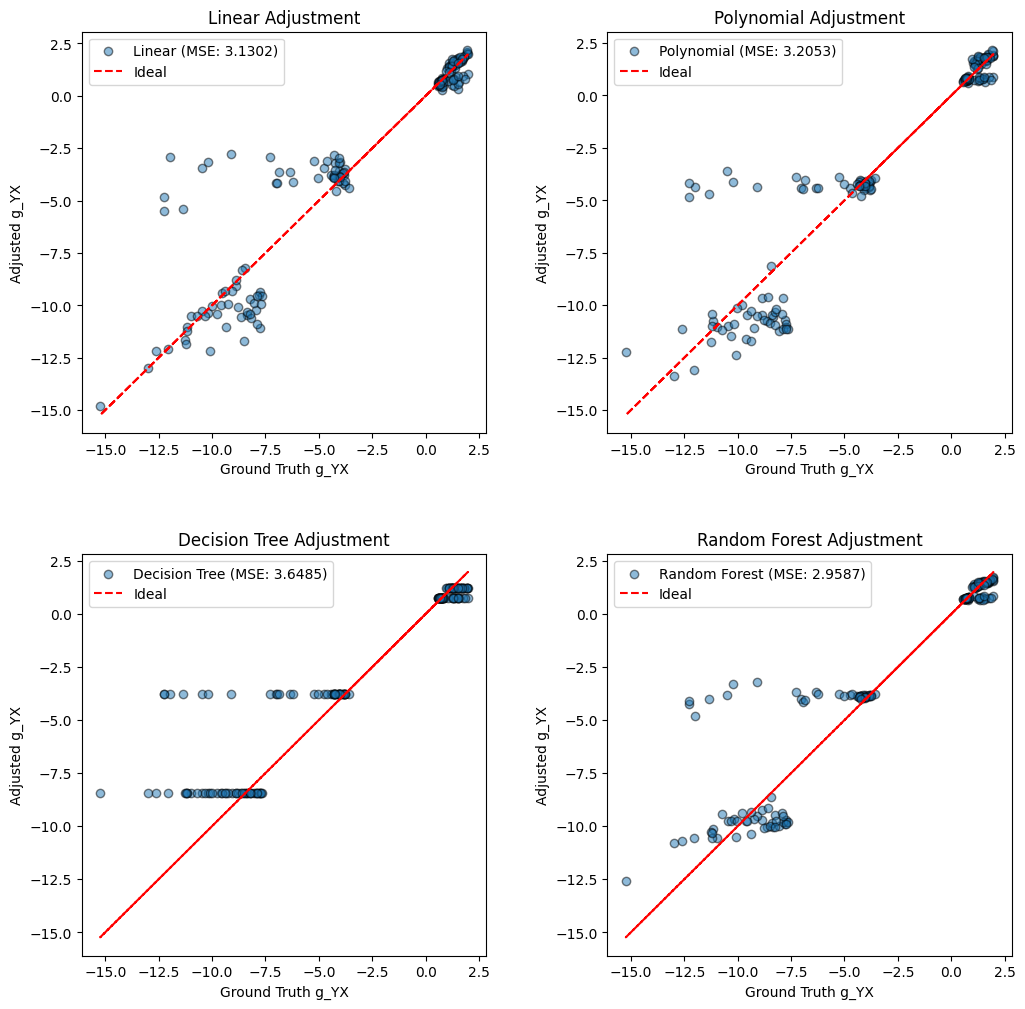

In [57]:
compare_adjustments(accepted_g_YX, adjusted_parameters_linear, adjusted_parameters_polynomial, adjusted_parameters_decision_tree, adjusted_parameters_random_forest, accepted_stats_e, accepted_stats_i)

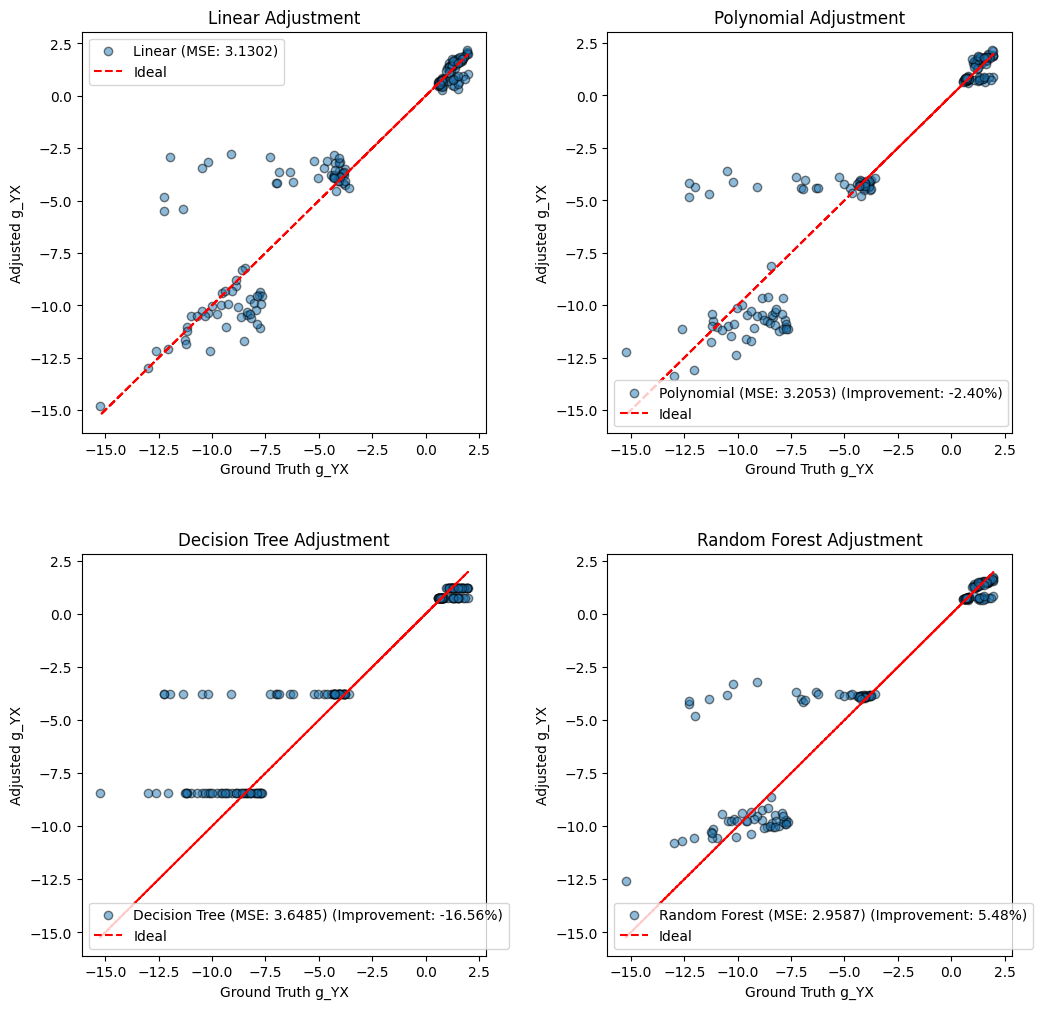

In [70]:
def compare_adjustments_v2(ground_truth_g_YX, adjusted_parameters_linear, adjusted_parameters_polynomial, adjusted_parameters_decision_tree, adjusted_parameters_random_forest):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    adjustment_methods = [
        ('Linear', adjusted_parameters_linear),
        ('Polynomial', adjusted_parameters_polynomial),
        ('Decision Tree', adjusted_parameters_decision_tree),
        ('Random Forest', adjusted_parameters_random_forest)
    ]

    ground_truth_array = np.array(ground_truth_g_YX)
    ground_truth_flat = ground_truth_array.flatten()
    mse_baseline = None

    for i, (method_name, adjusted_params) in enumerate(adjustment_methods):
        adjusted_flat = adjusted_params.flatten()
        mse = mean_squared_error(ground_truth_flat, adjusted_flat)

        if i == 0:
            mse_baseline = mse
            improvement_text = ''
        else:
            improvement = (mse_baseline - mse) / mse_baseline * 100
            improvement_text = f' (Improvement: {improvement:.2f}%)'

        ax = axes[i // 2, i % 2]
        scatter = ax.scatter(ground_truth_flat, adjusted_flat, alpha=0.5, edgecolors='k', label=f'{method_name} (MSE: {mse:.4f}){improvement_text}')
        ax.plot(ground_truth_flat, ground_truth_flat, color='red', linestyle='--', label='Ideal')
        ax.set_title(f'{method_name} Adjustment')
        ax.set_xlabel('Ground Truth g_YX')
        ax.set_ylabel('Adjusted g_YX')
        ax.legend()

    plt.show()

# Call the function with the appropriate arguments
compare_adjustments_v2(accepted_g_YX, adjusted_parameters_linear, adjusted_parameters_polynomial, adjusted_parameters_decision_tree, adjusted_parameters_random_forest)


ValueError: ignored

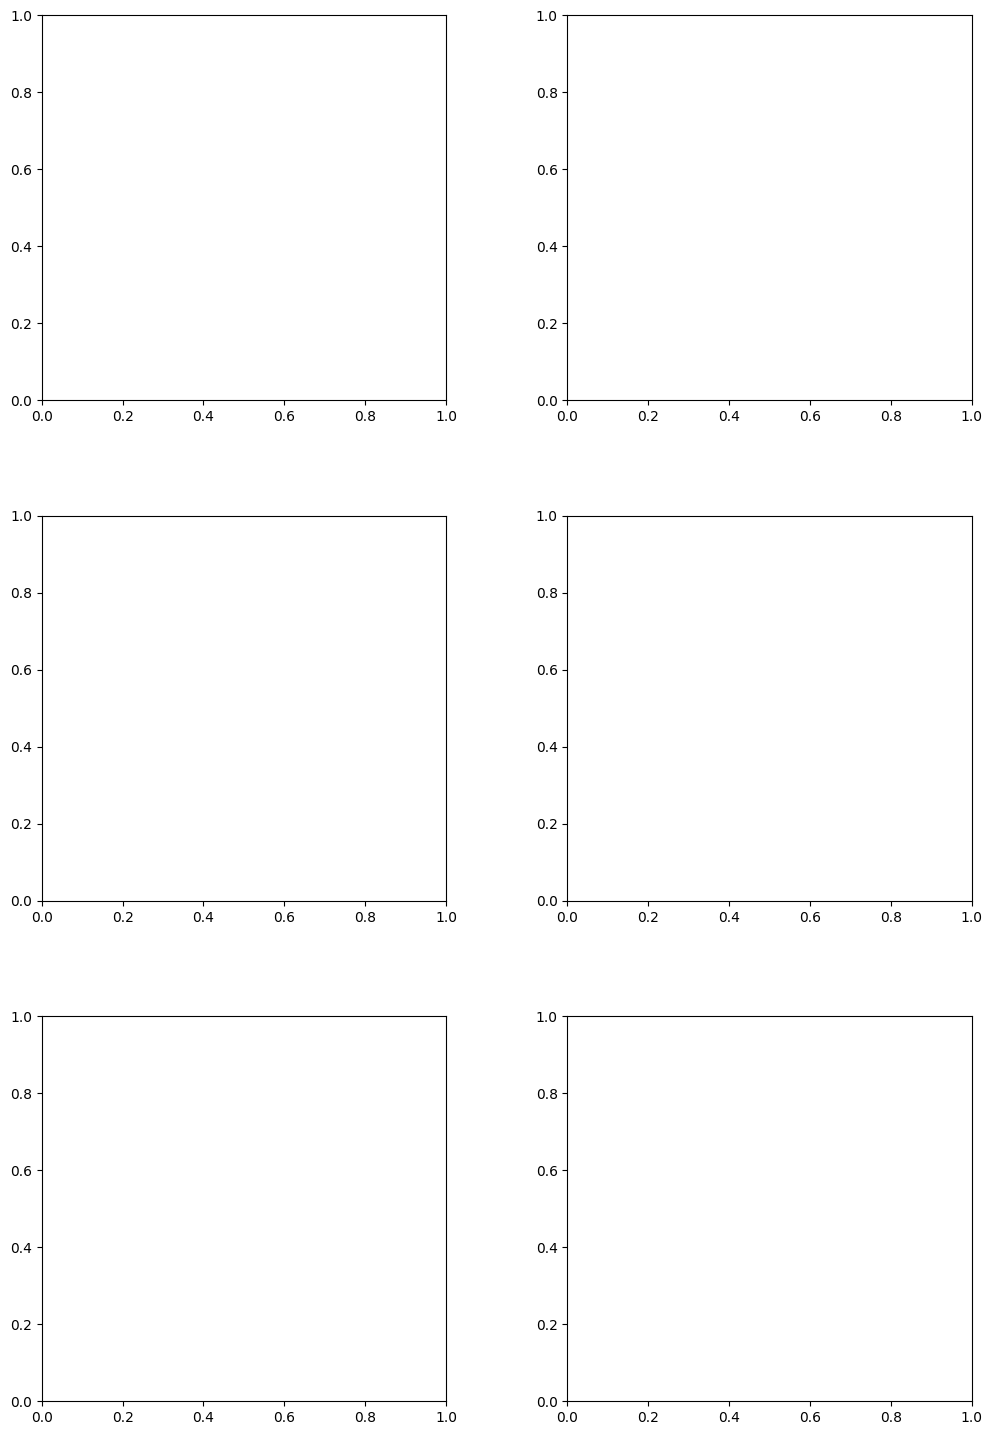

In [71]:
def compare_adjustments_v3(ground_truth_g_YX, unadjusted_parameters, adjusted_parameters_linear, adjusted_parameters_polynomial, adjusted_parameters_decision_tree, adjusted_parameters_random_forest):
    fig, axes = plt.subplots(3, 2, figsize=(12, 18))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    adjustment_methods = [
        ('Unadjusted', unadjusted_parameters),
        ('Linear', adjusted_parameters_linear),
        ('Polynomial', adjusted_parameters_polynomial),
        ('Decision Tree', adjusted_parameters_decision_tree),
        ('Random Forest', adjusted_parameters_random_forest)
    ]

    ground_truth_array = np.array(ground_truth_g_YX)
    ground_truth_flat = ground_truth_array.flatten()
    mse_baseline = None

    for i, (method_name, adjusted_params) in enumerate(adjustment_methods):
        adjusted_flat = adjusted_params.flatten()
        mse = mean_squared_error(ground_truth_flat, adjusted_flat)

        if i == 0:
            mse_baseline = mse
            improvement_text = ''
        else:
            improvement = (mse_baseline - mse) / mse_baseline * 100
            improvement_text = f' (Improvement: {improvement:.2f}%)'

        ax = axes[i // 2, i % 2]
        scatter = ax.scatter(ground_truth_flat, adjusted_flat, alpha=0.5, edgecolors='k', label=f'{method_name} (MSE: {mse:.4f}){improvement_text}')
        ax.plot(ground_truth_flat, ground_truth_flat, color='red', linestyle='--', label='Ideal')
        ax.set_title(f'{method_name} Adjustment')
        ax.set_xlabel('Ground Truth g_YX')
        ax.set_ylabel('Adjusted g_YX')
        ax.legend()

    plt.show()

# Extract the unadjusted g_YX from the accepted_params
unadjusted_parameters = np.array([param['g_YX'] for param in accepted_params])

# Call the function with the appropriate arguments
compare_adjustments_v3(accepted_g_YX, unadjusted_parameters, adjusted_parameters_linear, adjusted_parameters_polynomial, adjusted_parameters_decision_tree, adjusted_parameters_random_forest)


In [75]:
print("accepted_g_YX shape:", np.shape(accepted_g_YX))
print("unadjusted_parameters shape:", unadjusted_parameters.shape)
print("adjusted_parameters_linear shape:", adjusted_parameters_linear.shape)
print("adjusted_parameters_polynomial shape:", adjusted_parameters_polynomial.shape)
print("adjusted_parameters_decision_tree shape:", adjusted_parameters_decision_tree.shape)
print("adjusted_parameters_random_forest shape:", adjusted_parameters_random_forest.shape)


accepted_g_YX shape: (43, 2, 2)
unadjusted_parameters shape: (127, 2, 2)
adjusted_parameters_linear shape: (43, 2, 2)
adjusted_parameters_polynomial shape: (43, 2, 2)
adjusted_parameters_decision_tree shape: (43, 2, 2)
adjusted_parameters_random_forest shape: (43, 2, 2)
